# Training a Spiking Convolutional Neural Network for analysing DVS data

## Loading and understanding the training data

The data is stored in a folder of images, as often done while training neural networks. Each subfolder coincides with a class, and contains .png files of training examples.

We use a standard Torchvision dataset and dataloaders to read the data into PyTorch. The transformation is needed to provide images with the correct scale and a single channel.

In [33]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

FOLDER = '/home/martino/Work/synoploss/mnist_dvs/data/images/train'
BATCH_SIZE = 256

def transform(image):
    return ToTensor()(image)[0].unsqueeze(0) * 255

train_dataset = ImageFolder(
    root=FOLDER,
    transform=transform,
)

print("Number of training frames:", len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Number of training frames: 192995


The `train_dataset` object contains all our training images and labels, which are loaded into batches by the `train_dataloader` object.

Using `train_dataset`, try looking at how the data looks like. Plot one of the samples, which are 64x64 images, and print the corresponding label.

label: 0


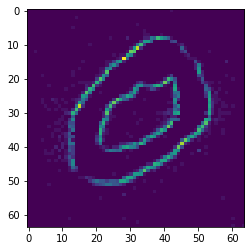

In [34]:
# to be left blank

sample, label = train_dataset[0]

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sample.squeeze())  # remove the extra dimension
print('label:', label)

## Defining a model

We now define our convolutional neural network. It will be a small network with 3 convolutional layers and one fully connected. Note that so far we are doing the exact same thing that we would do with traditional deep networks. There are no spikes yet.

In [35]:
import torch

class MNISTClassifier(torch.nn.Module):
    def __init__(self, quantize=False):
        super().__init__()

        self.seq = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8,
                            kernel_size=(3, 3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=8, out_channels=12,
                            kernel_size=(3, 3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=12, out_channels=12,
                            kernel_size=(3, 3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Dropout2d(0.5),
            torch.nn.Flatten(),
            torch.nn.Linear(432, 10, bias=False),
            torch.nn.ReLU(),   # note that it's needed, but odd, to add a ReLU at the end
        )

    def forward(self, x):
        return self.seq(x)


## Main training phase

We now want to train this network. Once again, this is no different from training a normal CNN. Only later, we will turn this network into a spiking network.

In [45]:
# instantiating the model and transferring to GPU
model = MNISTClassifier()
model.cuda()

# defining the loss function
criterion = torch.nn.CrossEntropyLoss()

# defining the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [39]:
# Set up a training loop
from tqdm.notebook import tqdm
n_epochs = 1

for epoch in range(n_epochs):
    print("Epoch", epoch+1)
    progress_bar = tqdm(train_dataloader)
    for (images, labels) in progress_bar:
        # move to the GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # reset the gradients
        optimizer.zero_grad()
        
        # forward pass through the network
        outputs = model(images)
        
        # compute and backpropagate the loss
        loss_value = criterion(outputs, labels)
        loss_value.backward()
        optimizer.step()
        progress_bar.set_postfix(LOSS=loss_value.item())
        
    # save the network, just in case
    torch.save(model.state_dict(), 'digits_net.pth')

Epoch 1


## Converting to a spiking network

To convert to a spiking network, we use the `from_torch` tool from `sinabs`, which reads a network (must be sequential, and only certain layers are supported), and converts it to the `sinabs` Network object, which supports all the dynamics of neurons on top of the convolutions.

In [50]:
# reload the model from saved, if necessary
model.load_state_dict(torch.load('digits_net.pth'))

<All keys matched successfully>

In [41]:
from sinabs.from_torch import from_model

net = from_model(
    model.seq,
    input_shape=(1, 64, 64),
    threshold=1.0,
    membrane_subtract=1.0,
    threshold_low=-5.0,
).cuda()

conv2d_0 (8, 62, 62)
avgpool_1 (8, 31, 31)
conv2d_2 (12, 29, 29)
avgpool_3 (12, 14, 14)
conv2d_4 (12, 12, 12)
avgpool_5 (12, 6, 6)
flatten (432,)
linear_7 (10,)


/home/martino/Work/sinabs/sinabs/from_torch.py:354: UserWarning: Layer 'Dropout2d' is not supported. Skipping!
  warn(f"Layer '{type(module).__name__}' is not supported. Skipping!")


## Live demo

Instead of properly testing our network on the test set, let's directly play with it in a real world scenario. We input DVS data into the network, and run it real-time, getting predictions about which digits were shown to the camera.

In [43]:
from aermanager import LiveDv

live = LiveDv(host='192.168.11.72', port=7777, qlen=64)

Process Process-1:
Traceback (most recent call last):
  File "/home/martino/.pyenv/versions/3.7.5/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/martino/.pyenv/versions/3.7.5/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/martino/Work/aermanager/aermanager/liveaer.py", line 47, in _build_q
    frame = next(self.nfi).image.squeeze()
  File "/home/martino/.local/lib/python3.7/site-packages/dv/NetworkInput.py", line 91, in __next__
    super().__next__()
  File "/home/martino/.local/lib/python3.7/site-packages/dv/NetworkInput.py", line 39, in __next__
    self._receive_next_packet()
  File "/home/martino/.local/lib/python3.7/site-packages/dv/NetworkInput.py", line 44, in _receive_next_packet
    packet_data = self._socket.recv(length, socket.MSG_WAITALL)
KeyboardInterrupt


In [41]:
# we resize and crop our input so that it matches the training data
adaptivepool = torch.nn.AdaptiveAvgPool2d((64, 64))
resize_factor = 16

def transform(x):
    x = x[:, :, 2:-2, 45:-45]  # crop
    x = torch.tensor(x).float().cuda()
    x = adaptivepool(x) * resize_factor
    return x

conv2d_0 (8, 62, 62)
avgpool_1 (8, 31, 31)
conv2d_2 (12, 29, 29)
avgpool_3 (12, 14, 14)
conv2d_4 (12, 12, 12)
avgpool_5 (12, 6, 6)
flatten (432,)
linear_7 (10,)


/home/martino/Work/sinabs/sinabs/from_torch.py:354: UserWarning: Layer 'Dropout2d' is not supported. Skipping!
  warn(f"Layer '{type(module).__name__}' is not supported. Skipping!")


In [44]:
from IPython.display import display, clear_output

while True:
    batch = live.get_batch()
    batch = transform(batch)

    out = net(batch)
    maxval, pred_label = torch.max(out.sum(0), dim=0)

    THR = 30
    clear_output()
    if maxval > THR:
        display(pred_label.item())
    else:
        display('.')

0

KeyboardInterrupt: 